In [19]:
import dask
import glob
import time
import random
import torch as py
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from multiprocessing import Pool, Manager
from matplotlib.ticker import FormatStrFormatter

In [20]:
# Load data
# --------------------------------------
ds1   = xr.open_dataset('/scratch/smata/data/ProcessedData_a0/second_pull/full_lidar.nc')
ds24  = xr.open_dataset('/scratch/smata/data/ProcessedData_a0/second_pull/full_4m_sonic.nc')
ds225 = xr.open_dataset('/scratch/smata/data/ProcessedData_a0/second_pull/full_25m_sonic.nc')
ds260 = xr.open_dataset('/scratch/smata/data/ProcessedData_a0/second_pull/full_60m_sonic.nc')
ds3   = xr.open_dataset('/scratch/smata/data/ProcessedData_a0/second_pull/full_stability.nc')
# ds4   = xr.open_dataset('/scratch/smata/data/ProcessedData_a0/second_pull/full_sonde.nc')

In [21]:
# Combine datasets on height dimension
# --------------------------------------
ds_combined = xr.concat([ds1, ds24, ds225, ds260], dim = 'height')
ds_combined = ds_combined.sortby('height')

In [22]:
# This deletes outlier heights from datasets
# --------------------------------------
del_heights = xr.open_dataset('/scratch/smata/data/ProcessedData_a0/second_pull/sgpdlprofwind4newsC1.c1.20210407.000054.nc')['height']
ds_combined = ds_combined.where(~ds_combined.height.isin(del_heights), drop = True)

In [23]:
# Remove outliers velocities
# --------------------------------------
for i in range(ds_combined.height.shape[0]):
    q90, q10 = np.nanpercentile(ds_combined['u'][i], [99.5, 0.5])
    ds_combined['u'][i] = ds_combined['u'][i].where((ds_combined['u'][i] >= q10) & (ds_combined['u'][i] <= q90), np.nan)
    q90, q10 = np.nanpercentile(ds_combined['v'][i], [99.5, 0.5])
    ds_combined['v'][i] = ds_combined['v'][i].where((ds_combined['v'][i] >= q10) & (ds_combined['v'][i] <= q90), np.nan)

In [24]:
# Interpolate to regular grid
# --------------------------------------
ds_combined = ds_combined.interp(height = np.arange(10, 2010, 10))

In [25]:
# Compute common time axis and cyclical time variables
# --------------------------------------

ref_date      = np.datetime64('2015-07-23T00:00:00.000000')

new_ref_times = np.empty(ds_combined.time.shape, dtype = 'datetime64[ns]')
hr_per_day    = np.zeros(new_ref_times.shape)
day_per_yr    = np.zeros(new_ref_times.shape)
times         = ds_combined.time.values

for i in range(ds_combined.time.shape[0]):
    new_ref_times[i] = np.datetime64((pd.Timestamp(ref_date) + pd.Timedelta(times[i], 'D')).round('min'))
    hr_per_day[i]    = pd.Timestamp(new_ref_times[i]).hour + pd.Timestamp(new_ref_times[i]).minute/60
    day_per_yr[i]    = new_ref_times[i].astype('datetime64[D]').astype(datetime).timetuple().tm_yday

ds_combined['hr_per_day']   = (('time'), hr_per_day)
ds_combined['day_per_yr']   = (('time'), day_per_yr)
ds_combined['hr_per_day_c'] = (('time'), np.cos(hr_per_day))
ds_combined['hr_per_day_s'] = (('time'), np.sin(hr_per_day))
ds_combined['day_per_yr_c'] = (('time'), np.cos(day_per_yr))
ds_combined['day_per_yr_s'] = (('time'), np.sin(day_per_yr))

In [26]:
# Generate copy/paste list of data bounds
# --------------------------------------
print(str(ds_combined['u'].min(skipna=True).values) + ',')
print(str(ds_combined['u'].max(skipna=True).values) + ',')
print(str(ds_combined['v'].min(skipna=True).values) + ',')
print(str(ds_combined['v'].max(skipna=True).values) + ',')
# print(str(ds_combined['hr_per_day_c'].min(skipna=True).values) + ',')
# print(str(ds_combined['hr_per_day_c'].max(skipna=True).values) + ',')
# print(str(ds_combined['hr_per_day_s'].min(skipna=True).values) + ',')
# print(str(ds_combined['hr_per_day_s'].max(skipna=True).values) + ',')
# print(str(ds_combined['day_per_yr_c'].min(skipna=True).values) + ',')
# print(str(ds_combined['day_per_yr_c'].max(skipna=True).values) + ',')
# print(str(ds_combined['day_per_yr_s'].min(skipna=True).values) + ',')
# print(str(ds_combined['day_per_yr_s'].max(skipna=True).values) + ',')

-14.145477391842705,
25.55866949139715,
-20.310099955027688,
27.949959019988107,


In [ ]:
# # Generate training, validation, and testing files in parallel
# # --------------------------------------

# if __name__ == '__main__':

#     avg_u    = ds_combined['u'].mean(skipna=True)
#     avg_v    = ds_combined['v'].mean(skipna=True)
#     avg_hpdc = ds_combined['hr_per_day_c'].mean(skipna=True)
#     avg_hpds = ds_combined['hr_per_day_s'].mean(skipna=True)
#     avg_dpyc = ds_combined['day_per_yr_c'].mean(skipna=True)
#     avg_dpys = ds_combined['day_per_yr_s'].mean(skipna=True)

#     shared_trv = []
#     shared_te  = []

#     day = np.arange(0, np.floor(np.max(ds_combined.time)), 1)
#     # day = np.arange(0, 20, 1)
#     te_index = np.random.choice(day, int(np.floor(0.2 * len(day))), replace=False)

#     def generate_file(day_value, te_index, shared_te, shared_trv):

#         extract_u    = ds_combined.u.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
#         extract_v    = ds_combined.v.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

#         extract_hpdc = ds_combined.hr_per_day_c.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
#         extract_hpds = ds_combined.hr_per_day_s.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

#         extract_dpyc = ds_combined.day_per_yr_c.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
#         extract_dpys = ds_combined.day_per_yr_s.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

#         extract_u[np.isnan(extract_u)]       = avg_u
#         extract_v[np.isnan(extract_v)]       = avg_v
#         extract_hpdc[np.isnan(extract_hpdc)] = avg_hpdc
#         extract_hpds[np.isnan(extract_hpds)] = avg_hpds
#         extract_dpyc[np.isnan(extract_dpyc)] = avg_dpyc
#         extract_dpys[np.isnan(extract_dpys)] = avg_dpys

#         array_u      = extract_u.T
#         array_v      = extract_v.T

#         array_hpdc   = (np.ones((extract_u.shape)) * extract_hpdc).T
#         array_hpds   = (np.ones((extract_u.shape)) * extract_hpds).T
#         array_dpyc   = (np.ones((extract_u.shape)) * extract_dpyc).T
#         array_dpys   = (np.ones((extract_u.shape)) * extract_dpys).T

#         tensor = py.stack([py.Tensor(array_u), py.Tensor(array_v), py.Tensor(array_hpdc), py.Tensor(array_hpds), py.Tensor(array_dpyc), py.Tensor(array_dpys)])

#         if tensor.shape[1] == 96:

#             path = '/scratch/smata/data/ProcessedData_a0/train_val_test/day_%04d.pt' % day_value

#             if day_value in te_index:
#                 shared_te.append(path + '\n')
#             else:
#                 shared_trv.append(path + '\n')

#             py.save({'x': tensor, 'y': tensor}, path)
#         else:
#             pass
        
#     start_time = time.time()

#     manager    = Manager()
#     shared_trv = manager.list()
#     shared_te  = manager.list()

#     # Parallel processing
#     with Pool(48) as pool:
#         pool.starmap(generate_file, [(d, te_index, shared_te, shared_trv) for d in day])

#     sorted_trv = sorted(shared_trv)
#     sorted_te  = sorted(shared_te)

#     with open('./train_and_val.flist', 'a') as file_trv, open('./test.flist', 'a') as file_te:
#         file_trv.writelines(sorted_trv)
#         file_te.writelines(sorted_te)

#     end_time = time.time()

#     print(f"Time: {end_time - start_time:.2f} seconds")

In [62]:
# Generate training, validation, and testing files in parallel for 4 sectors
# --------------------------------------

if __name__ == '__main__':

    avg_u    = ds_combined['u'].mean(skipna=True)
    avg_v    = ds_combined['v'].mean(skipna=True)
    avg_hpdc = ds_combined['hr_per_day_c'].mean(skipna=True)
    avg_hpds = ds_combined['hr_per_day_s'].mean(skipna=True)
    avg_dpyc = ds_combined['day_per_yr_c'].mean(skipna=True)
    avg_dpys = ds_combined['day_per_yr_s'].mean(skipna=True)

    shared_trv_s1 = []
    shared_trv_s2 = []
    shared_trv_s3 = []
    shared_trv_s4 = []
    shared_te_s1  = []
    shared_te_s2  = []
    shared_te_s3  = []
    shared_te_s4  = []

    day = np.arange(0, np.floor(np.max(ds_combined.time)), 1)
    # day = np.arange(0, 20, 1)
    te_index = np.random.choice(day, int(np.floor(0.2 * len(day))), replace=False)

    def generate_file(day_value, te_index, shared_te_s1, shared_te_s2, shared_te_s3, shared_te_s4, shared_trv_s1, shared_trv_s2, shared_trv_s3, shared_trv_s4):

        extract_u    = ds_combined.u.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
        extract_v    = ds_combined.v.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

        extract_hpdc = ds_combined.hr_per_day_c.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
        extract_hpds = ds_combined.hr_per_day_s.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

        extract_dpyc = ds_combined.day_per_yr_c.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
        extract_dpys = ds_combined.day_per_yr_s.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

        extract_u[np.isnan(extract_u)]       = avg_u
        extract_v[np.isnan(extract_v)]       = avg_v
        extract_hpdc[np.isnan(extract_hpdc)] = avg_hpdc
        extract_hpds[np.isnan(extract_hpds)] = avg_hpds
        extract_dpyc[np.isnan(extract_dpyc)] = avg_dpyc
        extract_dpys[np.isnan(extract_dpys)] = avg_dpys

        u_s1            = extract_u.copy()
        u_s2            = extract_u.copy()
        u_s3            = extract_u.copy()
        u_s4            = extract_u.copy()

        v_s1            = extract_v.copy()
        v_s2            = extract_v.copy()
        v_s3            = extract_v.copy()
        v_s4            = extract_v.copy()

        u_s1[0:50,:]    = avg_u # sector 1
        u_s2[50:100,:]  = avg_u # sector 2
        u_s3[100:150,:] = avg_u # sector 3
        u_s4[150:200,:] = avg_u # sector 4

        v_s1[0:50,:]    = avg_v # sector 1
        v_s2[50:100,:]  = avg_v # sector 2
        v_s3[100:150,:] = avg_v # sector 3
        v_s4[150:200,:] = avg_v # sector 4

        array_hpdc      = (np.ones((extract_u.shape)) * extract_hpdc).T
        array_hpds      = (np.ones((extract_u.shape)) * extract_hpds).T
        array_dpyc      = (np.ones((extract_u.shape)) * extract_dpyc).T
        array_dpys      = (np.ones((extract_u.shape)) * extract_dpys).T

        tensor_s1 = py.stack([py.Tensor(u_s1.T), py.Tensor(v_s1.T), py.Tensor(array_hpdc), py.Tensor(array_hpds), py.Tensor(array_dpyc), py.Tensor(array_dpys)])
        tensor_s2 = py.stack([py.Tensor(u_s2.T), py.Tensor(v_s2.T), py.Tensor(array_hpdc), py.Tensor(array_hpds), py.Tensor(array_dpyc), py.Tensor(array_dpys)])
        tensor_s3 = py.stack([py.Tensor(u_s3.T), py.Tensor(v_s3.T), py.Tensor(array_hpdc), py.Tensor(array_hpds), py.Tensor(array_dpyc), py.Tensor(array_dpys)])
        tensor_s4 = py.stack([py.Tensor(u_s4.T), py.Tensor(v_s4.T), py.Tensor(array_hpdc), py.Tensor(array_hpds), py.Tensor(array_dpyc), py.Tensor(array_dpys)])

        tensor_gt = py.stack([py.Tensor(extract_u.T), py.Tensor(extract_v.T), py.Tensor(array_hpdc), py.Tensor(array_hpds), py.Tensor(array_dpyc), py.Tensor(array_dpys)])

        if tensor_s1.shape[1] == 96:

            path_s1 = '/scratch/smata/data/ProcessedData_a0/sector_1/day_%04d.pt' % day_value
            path_s2 = '/scratch/smata/data/ProcessedData_a0/sector_2/day_%04d.pt' % day_value
            path_s3 = '/scratch/smata/data/ProcessedData_a0/sector_3/day_%04d.pt' % day_value
            path_s4 = '/scratch/smata/data/ProcessedData_a0/sector_4/day_%04d.pt' % day_value

            if day_value in te_index:
                shared_te_s1.append(path_s1 + '\n')
                shared_te_s2.append(path_s2 + '\n')
                shared_te_s3.append(path_s3 + '\n')
                shared_te_s4.append(path_s4 + '\n')
            else:
                shared_trv_s1.append(path_s1 + '\n')
                shared_trv_s2.append(path_s2 + '\n')
                shared_trv_s3.append(path_s3 + '\n')
                shared_trv_s4.append(path_s4 + '\n')

            py.save({'x': tensor_s1, 'y': tensor_gt}, path_s1)
            py.save({'x': tensor_s2, 'y': tensor_gt}, path_s2)
            py.save({'x': tensor_s3, 'y': tensor_gt}, path_s3)
            py.save({'x': tensor_s4, 'y': tensor_gt}, path_s4)
        else:
            pass
        
    start_time = time.time()

    manager    = Manager()
    shared_trv_s1 = manager.list()
    shared_trv_s2 = manager.list()
    shared_trv_s3 = manager.list()
    shared_trv_s4 = manager.list()
    shared_te_s1  = manager.list()
    shared_te_s2  = manager.list()
    shared_te_s3  = manager.list()
    shared_te_s4  = manager.list()

    # Parallel processing
    with Pool(48) as pool:
        pool.starmap(generate_file, [(d, te_index, shared_te_s1, shared_te_s2, shared_te_s3, shared_te_s4, shared_trv_s1, shared_trv_s2, shared_trv_s3, shared_trv_s4) for d in day])

    sorted_trv_s1 = sorted(shared_trv_s1)
    sorted_trv_s2 = sorted(shared_trv_s2)
    sorted_trv_s3 = sorted(shared_trv_s3)
    sorted_trv_s4 = sorted(shared_trv_s4)
    sorted_te_s1  = sorted(shared_te_s1)
    sorted_te_s2  = sorted(shared_te_s2)
    sorted_te_s3  = sorted(shared_te_s3)
    sorted_te_s4  = sorted(shared_te_s4)

    with open('/scratch/smata/PaletteDiffusionModel/data/flist/sector_1/train_and_val.flist', 'a') as file_trv, open('/scratch/smata/PaletteDiffusionModel/data/flist/sector_1/test.flist', 'a') as file_te:
        file_trv.writelines(sorted_trv_s1)
        file_te.writelines(sorted_te_s1)

    with open('/scratch/smata/PaletteDiffusionModel/data/flist/sector_2/train_and_val.flist', 'a') as file_trv, open('/scratch/smata/PaletteDiffusionModel/data/flist/sector_2/test.flist', 'a') as file_te:
        file_trv.writelines(sorted_trv_s2)
        file_te.writelines(sorted_te_s2)

    with open('/scratch/smata/PaletteDiffusionModel/data/flist/sector_3/train_and_val.flist', 'a') as file_trv, open('/scratch/smata/PaletteDiffusionModel/data/flist/sector_3/test.flist', 'a') as file_te:
        file_trv.writelines(sorted_trv_s3)
        file_te.writelines(sorted_te_s3)

    with open('/scratch/smata/PaletteDiffusionModel/data/flist/sector_4/train_and_val.flist', 'a') as file_trv, open('/scratch/smata/PaletteDiffusionModel/data/flist/sector_4/test.flist', 'a') as file_te:
        file_trv.writelines(sorted_trv_s4)
        file_te.writelines(sorted_te_s4)

    end_time = time.time()

    print(f"Time: {end_time - start_time:.2f} seconds")

Time: 38.69 seconds


In [27]:
# Just u and v with day and hour
# --------------------------------------

if __name__ == '__main__':

    avg_u    = ds_combined['u'].mean(skipna=True)
    avg_v    = ds_combined['v'].mean(skipna=True)

    shared_trv = []
    shared_te  = []

    day = np.arange(0, np.floor(np.max(ds_combined.time)), 1)
    # day = np.arange(0, 20, 1)
    te_index = np.random.choice(day, int(np.floor(0.2 * len(day))), replace=False)

    def generate_file(day_value, te_index, shared_te, shared_trv):

        extract_u   = ds_combined.u.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
        extract_v   = ds_combined.v.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

        extract_hpd = ds_combined.hr_per_day.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
        extract_dpy = ds_combined.day_per_yr.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

        img_sz = extract_u.shape[0] * extract_u.shape[1]

        u_nan = np.isnan(extract_u).sum()
        v_nan = np.isnan(extract_v).sum()

        extract_u[np.isnan(extract_u)]      = avg_u
        extract_v[np.isnan(extract_v)]      = avg_v

        array_hpd   = (np.ones((extract_u.shape)) * extract_hpd).T / 24
        array_dpy   = (np.ones((extract_u.shape)) * extract_dpy).T / 365

        tensor = py.stack([py.Tensor(extract_u.T), py.Tensor(extract_v.T), py.Tensor(array_hpd), py.Tensor(array_dpy)])

        if (tensor.shape[1] == 96) & (max([u_nan, v_nan])/img_sz < 0.75):

            path = '/scratch/smata/data/ProcessedData_a0/uvt/day_%04d.pt' % day_value

            if day_value in te_index:
                shared_te.append(path + '\n')
            else:
                shared_trv.append(path + '\n')

            py.save({'x': tensor, 'y': tensor}, path)
        else:
            pass
        
    start_time = time.time()

    manager    = Manager()
    shared_trv = manager.list()
    shared_te  = manager.list()

    # Parallel processing
    with Pool(48) as pool:
        pool.starmap(generate_file, [(d, te_index, shared_te, shared_trv) for d in day])

    sorted_trv = sorted(shared_trv)
    sorted_te  = sorted(shared_te)

    with open('/scratch/smata/PaletteDiffusionModel/data/flist/uvt/train_and_val.flist', 'a') as file_trv, open('/scratch/smata/PaletteDiffusionModel/data/flist/uvt/test.flist', 'a') as file_te:
        file_trv.writelines(sorted_trv)
        file_te.writelines(sorted_te)

    end_time = time.time()

    print(f"Time: {end_time - start_time:.2f} seconds")

/tmp/ipykernel_82937/1415095614.py:37: RuntimeWarning: invalid value encountered in scalar divide
  if (tensor.shape[1] == 96) & (max([u_nan, v_nan])/img_sz < 0.8):
/tmp/ipykernel_82937/1415095614.py:37: RuntimeWarning: invalid value encountered in scalar divide
  if (tensor.shape[1] == 96) & (max([u_nan, v_nan])/img_sz < 0.8):


Time: 35.42 seconds


In [ ]:
# Just u, v, and t
# --------------------------------------

if __name__ == '__main__':

    avg_u    = ds_combined['u'].mean(skipna=True)
    avg_v    = ds_combined['v'].mean(skipna=True)

    shared_trv = []
    shared_te  = []

    day = np.arange(0, np.floor(np.max(ds_combined.time)), 1)
    # day = np.arange(0, 20, 1)
    te_index = np.random.choice(day, int(np.floor(0.2 * len(day))), replace=False)

    def generate_file(day_value, te_index, shared_te, shared_trv):

        extract_u   = ds_combined.u.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
        extract_v   = ds_combined.v.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

        extract_hpd = ds_combined.hr_per_day.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
        extract_dpy = ds_combined.day_per_yr.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

        img_sz = extract_u.shape[0] * extract_u.shape[1]

        u_nan = np.isnan(extract_u).sum()
        v_nan = np.isnan(extract_v).sum()

        extract_u[np.isnan(extract_u)] = avg_u
        extract_v[np.isnan(extract_v)] = avg_v

        array_hpd = (np.ones((extract_u.shape)) * extract_hpd).T / 24
        array_dpy = (np.ones((extract_u.shape)) * extract_dpy).T
        array_t   = (array_dpy + array_hpd) / 365

        tensor    = py.stack([py.Tensor(extract_u.T), py.Tensor(extract_v.T), py.Tensor(array_t)])

        if (tensor.shape[1] == 96) & (max([u_nan, v_nan])/img_sz < 0.75):

            path = '/scratch/smata/data/ProcessedData_a0/uvt/day_%04d.pt' % day_value

            if day_value in te_index:
                shared_te.append(path + '\n')
            else:
                shared_trv.append(path + '\n')

            py.save({'x': tensor, 'y': tensor}, path)
        else:
            pass
        
    start_time = time.time()

    manager    = Manager()
    shared_trv = manager.list()
    shared_te  = manager.list()

    # Parallel processing
    with Pool(48) as pool:
        pool.starmap(generate_file, [(d, te_index, shared_te, shared_trv) for d in day])

    sorted_trv = sorted(shared_trv)
    sorted_te  = sorted(shared_te)

    with open('/scratch/smata/PaletteDiffusionModel/data/flist/uvt/train_and_val.flist', 'a') as file_trv, open('/scratch/smata/PaletteDiffusionModel/data/flist/uvt/test.flist', 'a') as file_te:
        file_trv.writelines(sorted_trv)
        file_te.writelines(sorted_te)

    end_time = time.time()

    print(f"Time: {end_time - start_time:.2f} seconds")

/tmp/ipykernel_82937/1415095614.py:37: RuntimeWarning: invalid value encountered in scalar divide
  if (tensor.shape[1] == 96) & (max([u_nan, v_nan])/img_sz < 0.8):
/tmp/ipykernel_82937/1415095614.py:37: RuntimeWarning: invalid value encountered in scalar divide
  if (tensor.shape[1] == 96) & (max([u_nan, v_nan])/img_sz < 0.8):


Time: 35.42 seconds


In [9]:
# Just u and v
# --------------------------------------

if __name__ == '__main__':

    avg_u    = ds_combined['u'].mean(skipna=True)
    avg_v    = ds_combined['v'].mean(skipna=True)

    shared_trv = []
    shared_te  = []

    day = np.arange(0, np.floor(np.max(ds_combined.time)), 1)
    # day = np.arange(0, 20, 1)
    te_index = np.random.choice(day, int(np.floor(0.2 * len(day))), replace=False)

    def generate_file(day_value, te_index, shared_te, shared_trv):

        extract_u    = ds_combined.u.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
        extract_v    = ds_combined.v.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

        extract_u[np.isnan(extract_u)]       = avg_u
        extract_v[np.isnan(extract_v)]       = avg_v

        tensor = py.stack([py.Tensor(extract_u.T), py.Tensor(extract_v.T)])

        if tensor.shape[1] == 96:

            path = '/scratch/smata/data/ProcessedData_a0/train_val_test_just_uv/day_%04d.pt' % day_value

            if day_value in te_index:
                shared_te.append(path + '\n')
            else:
                shared_trv.append(path + '\n')

            py.save({'x': tensor, 'y': tensor}, path)
        else:
            pass
        
    start_time = time.time()

    manager    = Manager()
    shared_trv = manager.list()
    shared_te  = manager.list()

    # Parallel processing
    with Pool(48) as pool:
        pool.starmap(generate_file, [(d, te_index, shared_te, shared_trv) for d in day])

    sorted_trv = sorted(shared_trv)
    sorted_te  = sorted(shared_te)

    with open('/scratch/smata/PaletteDiffusionModel/data/flist/just_uv/train_and_val.flist', 'a') as file_trv, open('/scratch/smata/PaletteDiffusionModel/data/flist/just_uv/test.flist', 'a') as file_te:
        file_trv.writelines(sorted_trv)
        file_te.writelines(sorted_te)

    end_time = time.time()

    print(f"Time: {end_time - start_time:.2f} seconds")

Time: 56.61 seconds


### Various plotting and QC scripts

In [8]:
# # Plot time-varying profiles
# # --------------------------------------

# fig,ax = plt.subplots(figsize = (15, 4))

# cntf = ax.pcolormesh(ds_combined['time'], ds_combined['height'], ds_combined['u'], vmin = -8, vmax = 15)
# ax.set_ylabel("$z$ [m]", color = 'w')
# ax.set_ylim([0, 2000])

# cb_ax = fig.add_axes([0.905, 0.1125, 0.015, 0.768])
# cbar = fig.colorbar(cntf, orientation='vertical', cax = cb_ax)
# cbar.set_label('$u$ component [m/s]', rotation = 270, labelpad = 15, color = 'k')
# # cbar.outline.set_color('white')
# # cbar.ax.yaxis.set_tick_params(color = 'w')
# # plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'w')

# # for spine in ax.spines.values():
#     # spine.set_edgecolor('w')

# ax.set_xticks((np.array([360, 725, 1090, 1440, 1800, 2160, 2520, 2880, 3240]) - 204), ["2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"])
# # ax.set_title(f'Profiles: {common_time.shape[0]:,}', color = 'w')

# # ax.tick_params(axis = 'x', colors = 'w')
# # ax.tick_params(axis = 'y', colors = 'w')

In [9]:
# # Plot time-varying profiles
# # --------------------------------------

# fig,ax = plt.subplots(figsize = (15, 4))

# cntf = ax.pcolormesh(ds_combined['time'], ds_combined['height'], ds_combined['v'], vmin = -8, vmax = 20)
# ax.set_ylabel("$z$ [m]", color = 'w')
# ax.set_ylim([0, 2000])

# cb_ax = fig.add_axes([0.905, 0.1125, 0.015, 0.768])
# cbar = fig.colorbar(cntf, orientation='vertical', cax = cb_ax)
# cbar.set_label('$v$ component [m/s]', rotation = 270, labelpad = 15, color = 'k')
# # cbar.outline.set_color('white')
# # cbar.ax.yaxis.set_tick_params(color = 'w')
# # plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'w')

# # for spine in ax.spines.values():
#     # spine.set_edgecolor('w')

# ax.set_xticks((np.array([360, 725, 1090, 1440, 1800, 2160, 2520, 2880, 3240]) - 204), ["2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"])
# # ax.set_title(f'Profiles: {common_time.shape[0]:,}', color = 'w')

# # ax.tick_params(axis = 'x', colors = 'w')
# # ax.tick_params(axis = 'y', colors = 'w')

In [10]:
# # Plot time-varying profiles
# # --------------------------------------

# fig,ax = plt.subplots(figsize = (15, 6))

# cntf = ax.pcolormesh(ds_combined['time'], ds_combined['height'], (ds_combined['v']**2 + ds_combined['u']**2)**(0.5), vmin = 0, vmax = 20)
# ax.set_ylabel("$z$ [m]", color = 'k')
# ax.set_ylim([0, 2000])

# cb_ax = fig.add_axes([0.905, 0.1125, 0.015, 0.768])
# cbar = fig.colorbar(cntf, orientation='vertical', cax = cb_ax)
# cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 15, color = 'k')
# # cbar.outline.set_color('white')
# # cbar.ax.yaxis.set_tick_params(color = 'w')
# # plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'w')

# # for spine in ax.spines.values():
#     # spine.set_edgecolor('w')

# ax.set_xticks((np.array([360, 725, 1090, 1440, 1800, 2160, 2520, 2880, 3240]) - 204), ["2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"])
# # ax.set_title(f'Profiles: {common_time.shape[0]:,}', color = 'w')

# # ax.tick_params(axis = 'x', colors = 'w')
# # ax.tick_params(axis = 'y', colors = 'w')

# plt.savefig('./large_data.png', dpi = 700, bbox_inches = 'tight', transparent = True)


In [12]:
# # Confirm time axes are correct
# # --------------------------------------

# fig,ax = plt.subplots(figsize = (7, 7))

# # ax[0].plot(times, hr_per_day)
# ax.hist(hr_per_day, bins = 46, edgecolor = 'black')
# # ax.set_xlim([0, 23])
# # x[0].plot(range(len(times)), hr_per_day)
# ax.set_xlabel('Fractional hour of day')
# ax.set_ylabel('Count')

In [13]:
# # Plot rectified wind profiles
# # --------------------------------------

# plt.style.use('dark_background')

# fig,ax = plt.subplots(3, 1, figsize = (15, 8), sharex = True)

# cntf = ax[0].pcolormesh(ds_combined['time'], ds_combined['height'], ds_combined['u'], vmin = -15, vmax = 15,  cmap = 'twilight_shifted')
# cbar = plt.colorbar(cntf)
# cbar.set_label('$u$ component [m/s]', rotation = 270, labelpad = 20)
# ax[0].set_ylabel("$z$ [m]")
# ax[0].set_ylim([0, 2000])
# ax[0].get_xaxis().set_ticks([])

# cntf = ax[1].pcolormesh(ds_combined['time'], ds_combined['height'], ds_combined['v'], vmin = -15, vmax = 15,  cmap = 'twilight_shifted')
# cbar = plt.colorbar(cntf)
# cbar.set_label('$v$ component [m/s]', rotation = 270, labelpad = 20)
# ax[1].set_ylabel("$z$ [m]")
# ax[1].set_ylim([0, 2000])
# ax[1].get_xaxis().set_ticks([])

# cntf = ax[2].pcolormesh(ds_combined['time'], ds_combined['height'], (ds_combined['u']**2 + ds_combined['v']**2)**(1/2), vmin = 0, vmax = 20, cmap = 'viridis')
# cbar = plt.colorbar(cntf)
# cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 20)
# # ax[2].set_xlabel("Profile index [-]")
# ax[2].set_ylabel("$z$ [m]")
# ax[2].set_ylim([0, 2000])
# ax[2].set_xticks((np.array([360, 725, 1090, 1440, 1800, 2160, 2520, 2880, 3240]) - 204), ["2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"])

# plt.savefig('./large_data_uv.png', dpi = 750, bbox_inches = 'tight', transparent = True)


In [14]:
# day = 5

# extract_u = ds_combined.u.where((ds_combined.time >= day) & (ds_combined.time < (day + 1)), drop=True)
# extract_v = ds_combined.v.where((ds_combined.time >= day) & (ds_combined.time < (day + 1)), drop=True)

# extract_t = ds_combined.time.where((ds_combined.time >= day) & (ds_combined.time < (day + 1)), drop=True)

# fig,ax = plt.subplots(figsize = (6, 8))

# cntf = ax.pcolormesh(extract_t, ds_combined['height'], (extract_u**(2) + extract_v)**(0.5), vmin = 0, vmax = 15)
# ax.set_ylabel("$z$ [m]")
# ax.set_xlabel("Day Index [-]")
# ax.set_ylim([0, 2000])

# cb_ax = fig.add_axes([0.91, 0.11, 0.025, 0.77])
# cbar = fig.colorbar(cntf, orientation='vertical', cax = cb_ax)
# cbar.set_label('Wind Speed [m/s]', rotation = 270, labelpad = 12, color = 'k')

# plt.savefig('./large_data.png', dpi = 700, bbox_inches = 'tight', transparent = True)

In [ ]:
# # Generate training, validation, and testing files in serial
# # --------------------------------------

# avg_u    = ds_combined['u'].mean(skipna=True)
# avg_v    = ds_combined['v'].mean(skipna=True)
# avg_hpdc = ds_combined['hr_per_day_c'].mean(skipna=True)
# avg_hpds = ds_combined['hr_per_day_s'].mean(skipna=True)
# avg_dpyc = ds_combined['day_per_yr_c'].mean(skipna=True)
# avg_dpys = ds_combined['day_per_yr_s'].mean(skipna=True)

# file_trv = open('./train_and_val.flist', 'a')
# file_te  = open('./test.flist', 'a')

# day = np.arange(0, np.floor(np.max(ds_combined.time)), 1)
# # day = np.arange(0, 20, 1)
# te_index = np.random.choice(day, int(np.floor(0.2 * len(day))), replace=False)

# for i in range(len(day)):

#     extract_u    = ds_combined.u.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values
#     extract_v    = ds_combined.v.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values

#     extract_hpdc = ds_combined.hr_per_day_c.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values
#     extract_hpds = ds_combined.hr_per_day_s.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values

#     extract_dpyc = ds_combined.day_per_yr_c.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values
#     extract_dpys = ds_combined.day_per_yr_s.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values

#     extract_u[np.isnan(extract_u)]       = avg_u
#     extract_v[np.isnan(extract_v)]       = avg_v
#     extract_hpdc[np.isnan(extract_hpdc)] = avg_hpdc
#     extract_hpds[np.isnan(extract_hpds)] = avg_hpds
#     extract_dpyc[np.isnan(extract_dpyc)] = avg_dpyc
#     extract_dpys[np.isnan(extract_dpys)] = avg_dpys

#     array_u      = extract_u.T
#     array_v      = extract_v.T

#     array_hpdc   = (np.ones((extract_u.shape)) * extract_hpdc).T
#     array_hpds   = (np.ones((extract_u.shape)) * extract_hpds).T
#     array_dpyc   = (np.ones((extract_u.shape)) * extract_dpyc).T
#     array_dpys   = (np.ones((extract_u.shape)) * extract_dpys).T

#     tensor = py.stack([py.Tensor(array_u), py.Tensor(array_v), py.Tensor(array_hpdc), py.Tensor(array_hpds), py.Tensor(array_dpyc), py.Tensor(array_dpys)])

#     if i in te_index:
#         path = '/scratch/smata/data/ProcessedData_a0/test/day_%04d.pt' % i
#         file_te.write(path + '\n')
#     else:
#         path = '/scratch/smata/data/ProcessedData_a0/train_and_validation/day_%04d.pt' % i
#         file_trv.write(path + '\n')

#     py.save({'x': tensor, 'y': tensor}, '/scratch/smata/data/ProcessedData_a0/train_val_test/day_%04d.pt' % i)

# file_trv.close()
# file_te.close()

Text(0.5, 0, 'Day Index [-]')

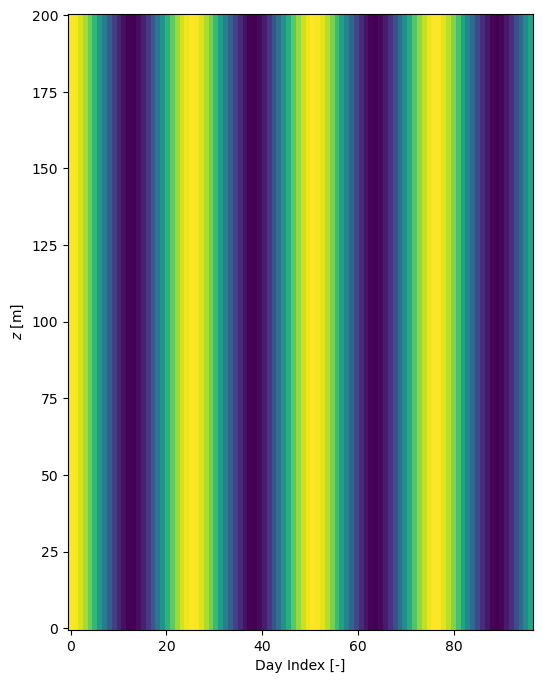

In [44]:
# Generate training, validation, and testing files in serial
# --------------------------------------

avg_u    = ds_combined['u'].mean(skipna=True)
avg_v    = ds_combined['v'].mean(skipna=True)
avg_hpdc = ds_combined['hr_per_day_c'].mean(skipna=True)
avg_hpds = ds_combined['hr_per_day_s'].mean(skipna=True)
avg_dpyc = ds_combined['day_per_yr_c'].mean(skipna=True)
avg_dpys = ds_combined['day_per_yr_s'].mean(skipna=True)

file_trv = open('./train_and_val.flist', 'a')
file_te  = open('./test.flist', 'a')

day = np.arange(0, np.floor(np.max(ds_combined.time)), 1)
# day = np.arange(0, 20, 1)
te_index = np.random.choice(day, int(np.floor(0.2 * len(day))), replace=False)

i = 1

extract_u    = ds_combined.u.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values
extract_v    = ds_combined.v.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values

extract_hpdc = ds_combined.hr_per_day_c.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values
extract_hpds = ds_combined.hr_per_day_s.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values

extract_dpyc = ds_combined.day_per_yr_c.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values
extract_dpys = ds_combined.day_per_yr_s.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values

extract_u[np.isnan(extract_u)]       = avg_u
extract_v[np.isnan(extract_v)]       = avg_v
extract_hpdc[np.isnan(extract_hpdc)] = avg_hpdc
extract_hpds[np.isnan(extract_hpds)] = avg_hpds
extract_dpyc[np.isnan(extract_dpyc)] = avg_dpyc
extract_dpys[np.isnan(extract_dpys)] = avg_dpys

u_s1            = extract_u.copy()
u_s2            = extract_u.copy()
u_s3            = extract_u.copy()
u_s4            = extract_u.copy()

v_s1            = extract_v.copy()
v_s2            = extract_v.copy()
v_s3            = extract_v.copy()
v_s4            = extract_v.copy()

u_s1[0:50,:]    = avg_u # sector 1
u_s2[50:100,:]  = avg_u # sector 2
u_s3[100:150,:] = avg_u # sector 3
u_s4[150:200,:] = avg_u # sector 4

v_s1[0:50,:]    = avg_v # sector 1
v_s2[50:100,:]  = avg_v # sector 2
v_s3[100:150,:] = avg_v # sector 3
v_s4[150:200,:] = avg_v # sector 4

# array_u      = extract_u.T
# array_v      = extract_v.T

array_hpdc   = (np.ones((extract_u.shape)) * extract_hpdc).T
array_hpds   = (np.ones((extract_u.shape)) * extract_hpds).T
array_dpyc   = (np.ones((extract_u.shape)) * extract_dpyc).T
array_dpys   = (np.ones((extract_u.shape)) * extract_dpys).T

tensor_s1 = py.stack([py.Tensor(u_s1.T), py.Tensor(v_s1.T), py.Tensor(array_hpdc), py.Tensor(array_hpds), py.Tensor(array_dpyc), py.Tensor(array_dpys)])
tensor_s2 = py.stack([py.Tensor(u_s2.T), py.Tensor(v_s2.T), py.Tensor(array_hpdc), py.Tensor(array_hpds), py.Tensor(array_dpyc), py.Tensor(array_dpys)])
tensor_s3 = py.stack([py.Tensor(u_s3.T), py.Tensor(v_s3.T), py.Tensor(array_hpdc), py.Tensor(array_hpds), py.Tensor(array_dpyc), py.Tensor(array_dpys)])
tensor_s4 = py.stack([py.Tensor(u_s4.T), py.Tensor(v_s4.T), py.Tensor(array_hpdc), py.Tensor(array_hpds), py.Tensor(array_dpyc), py.Tensor(array_dpys)])

extract_u.shape

fig,ax = plt.subplots(figsize = (6, 8))

cntf = ax.pcolormesh(np.linspace(0, 96, 96), np.linspace(0, 200, 200), array_hpdc.T)

ax.set_ylabel("$z$ [m]")
ax.set_xlabel("Day Index [-]")

In [57]:
# Generate movie of snapshots
# --------------------------------------
day = np.arange(1, 11, 1/96)

for i in range(len(day)):

    extract_u = ds_combined.u.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True)
    extract_v = ds_combined.v.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True)

    extract_t = ds_combined.time.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True)

    plt.style.use('dark_background')

    fig,ax = plt.subplots(figsize = (6, 8))

    cntf = ax.pcolormesh(extract_t, ds_combined['height'], (extract_u**(2) + extract_v)**(0.5), vmin = 0, vmax = 15)
    ax.set_ylabel("$z$ [m]")
    ax.set_xlabel("Day Index [-]")
    ax.set_ylim([0, 2000])

    cb_ax = fig.add_axes([0.91, 0.11, 0.025, 0.77])
    cbar = fig.colorbar(cntf, orientation='vertical', cax = cb_ax)
    cbar.set_label('Wind Speed [m/s]', rotation = 270, labelpad = 12)

    plt.savefig('./snapshots/snap_%04d.png' % i, dpi = 420, bbox_inches = 'tight', transparent = False)

    plt.close()

In [2]:
# Inspect sample files
# --------------------------------------
# mmm = py.load('/scratch/smata/data/ProcessedData_a0/sector_1/day_2960.pt')
mmm = py.load('/scratch/smata/data/ProcessedData_a0/train_val_test/day_0109.pt')
# mmm = py.load('/scratch/smata/diffusion_test/data/files/train/sample_0001_02.pt')

type(mmm)

mmm.keys()

mmm['x']

mmm['x'].shape

# mmm['y'][3,:,:]

/tmp/ipykernel_3039279/2795221451.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mmm = py.load('/scratch/smata/data/ProcessedData_a0/train_val_test/day_0109.pt')


torch.Size([6, 96, 200])

Text(0.5, 0, 'Day Index [-]')

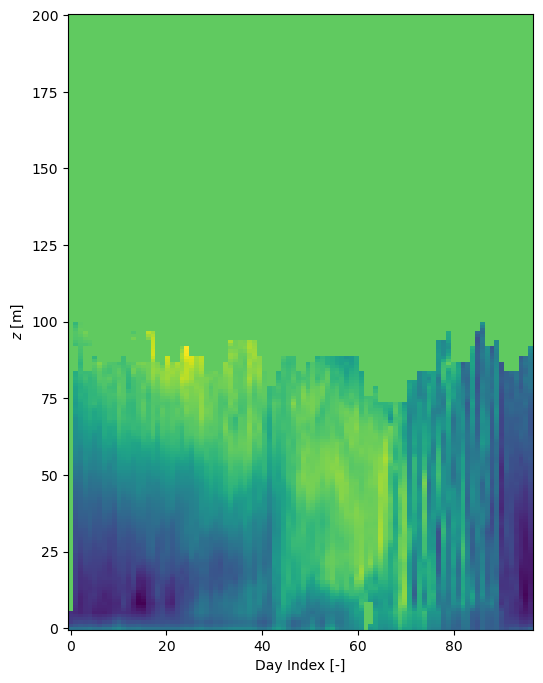

In [4]:
fig,ax = plt.subplots(figsize = (6, 8))

cntf = ax.pcolormesh(np.linspace(0, 96, 96), np.linspace(0, 200, 200), mmm['x'][0,:,:].T)
#
# cntf = ax.pcolormesh(np.linspace(0, 704, 704), np.linspace(0, 32, 32), mmm['y'][2,:,:].T)
ax.set_ylabel("$z$ [m]")
ax.set_xlabel("Day Index [-]")



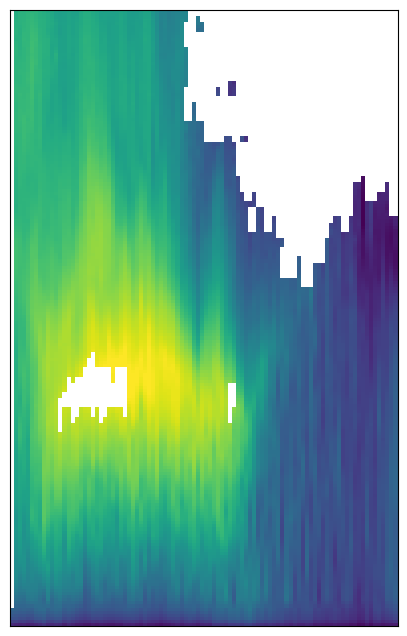

In [170]:
day = 2483

font = 13

extract_u = ds_combined.u.where((ds_combined.time >= day) & (ds_combined.time < (day + 1)), drop=True).values
extract_v = ds_combined.v.where((ds_combined.time >= day) & (ds_combined.time < (day + 1)), drop=True).values

fig, ax = plt.subplots(figsize=(5, 8))

cntf = ax.pcolormesh(np.linspace(0, 96, 96), np.linspace(0, 2000, 200), (extract_u**2 + extract_v**2)**(1/2), vmin = 5, vmax = 30)

# Add horizontal dashed red line at y = 250
# ax.axhline(y=250, color='#d7d9d9', linestyle='--') #red
# ax.axhline(y=250, color='#e67207', linestyle='--') #orange


# Add a colorbar
# cb_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
# cbar = fig.colorbar(cntf, orientation = 'vertical', cax = cb_ax)
# cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 15, fontsize = font)
# cbar.ax.tick_params(labelsize=font)

# ax.text(x=96, y=210, s="Wind Energy Zone", color='#e67207', fontsize=9, ha='right', fontweight='bold')
# ax.text(x=1, y=210, s="Wind Energy Zone", color='#e67207', fontsize=9, ha='left', fontweight='bold')
# ax.text(x=1, y=210, s="Wind Energy Zone", color='#ce3431', fontsize=9, ha='left', fontweight='bold')
# ax.text(x=1, y=210, s="Wind Energy Zone", color='#f2f2f2', fontsize=9, ha='left', fontweight='bold')



# ax.set_ylabel("$z$ [m]", fontsize=font)  # Increase font size for y-axis label
# ax.set_xlabel("Hour of day", fontsize=font)  # Increase font size for x-axis label

# Set x ticks every 12 steps with labels 0, 8, 16, ...
x_ticks = np.arange(0, 97, 24)
x_labels = np.arange(0, 25, 6)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)

# Increase tick mark font size
ax.tick_params(axis='both', which='major', labelsize=font)

# ax.set_title('LiDAR Wind Profiles', fontsize=font*1.5)

# ax.axis('off')
# Turn off all axes labels and ticks
ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks
ax.set_xticklabels([])  # Remove x-axis labels
ax.set_yticklabels([])  # Remove y-axis labels

# plt.savefig('./ensemble_13.png', dpi = 800, bbox_inches = 'tight', transparent = True)

plt.show()


In [74]:
import numpy as np
from PIL import Image

# Load the image
image = Image.open('./diffusion_eg.jpg')
image_array = np.array(image)

# Generate Gaussian noise
mean = 0
std = 25  # Standard deviation of the noise
noise = np.random.normal(mean, std, image_array.shape)

noisy_image_array = image_array + noise

for i in range(25):
    # Add the noise to the image
    noisy_image_array = noisy_image_array + noise

# Clip pixel values to be in the correct range
noisy_image_array = np.clip(noisy_image_array, 0, 255).astype(np.uint8)

# Convert back to an image
noisy_image = Image.fromarray(noisy_image_array)

# Save or display the image
# noisy_image.show()
# noisy_image.save('noisy_image.jpg')

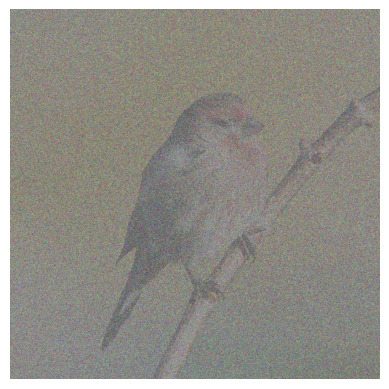

In [75]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
# image = Image.open('./diffusion_eg.jpg')
# image_array = np.array(image)
# noisy_image_array = image_array
# noisy_image_array = np.clip(noisy_image_array, 0, 255).astype(np.uint8)
# noisy_image = Image.fromarray(noisy_image_array)



# img = mpimg.imread(noisy_image)
imgplot = plt.imshow(noisy_image)
plt.axis('off')
plt.savefig('./bird_f_3.png', dpi = 800, bbox_inches = 'tight', transparent = True)
plt.show()


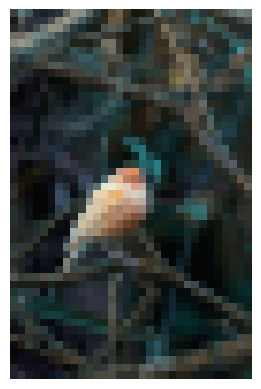

In [93]:
from PIL import Image
import cv2

# Load the original image
image = cv2.imread('./super_res_eg.jpg')

# Reduce resolution by resizing (e.g., half the original dimensions)
# Reduce resolution by resizing (e.g., half the original dimensions)
new_width, new_height = image.shape[1] // 100, image.shape[0] // 100
low_res_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

# Convert the color from BGR to RGB
low_res_image_rgb = cv2.cvtColor(low_res_image, cv2.COLOR_BGR2RGB)


# Optionally, resize back to the original size to simulate lower resolution
# low_res_image = low_res_image.resize(image.size, Image.Resampling.LANCZOS)

# Display the low-resolution image
# img = mpimg.imread(noisy_image)
imgplot = plt.imshow(low_res_image_rgb)
plt.axis('off')
plt.savefig('./bird_low_res.png', dpi = 800, bbox_inches = 'tight', transparent = True)
plt.show()

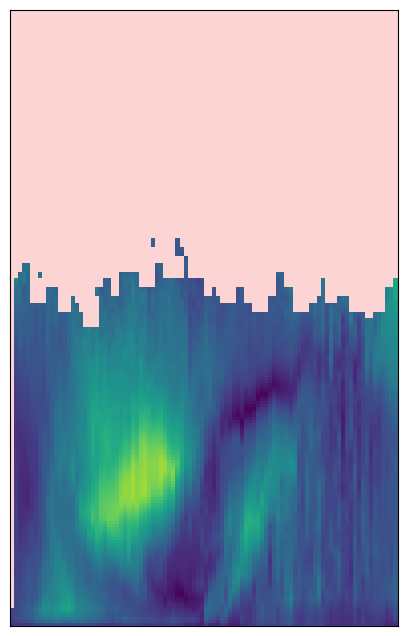

In [237]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

day  = 83

font = 13

extract_u = ds_combined.u.where((ds_combined.time >= day) & (ds_combined.time < (day + 1)), drop=True).values
extract_v = ds_combined.v.where((ds_combined.time >= day) & (ds_combined.time < (day + 1)), drop=True).values

ws = (extract_u**2 + extract_v**2)**(1/2)

# Generate Gaussian noise
mean =np.nanmean(ws)
std = np.nanstd(ws)

noise = np.random.normal(mean, std, (30, 96))

cmap = plt.cm.viridis  # You can choose any colormap you like
cmap.set_bad(color='#fcd4d4')

# ws[20:50, :] = noise

fig, ax = plt.subplots(figsize=(5, 8))

cntf = ax.pcolormesh(np.linspace(0, 96, 96), np.linspace(0, 200, 200), ws, vmin = 0, vmax = 20, cmap = cmap)

# Increase tick mark font size
ax.tick_params(axis='both', which='major', labelsize=font)

# ax.set_title('LiDAR Wind Profiles', fontsize=font*1.5)

# ax.axis('off')
# Turn off all axes labels and ticks
ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks
ax.set_xticklabels([])  # Remove x-axis labels
ax.set_yticklabels([])  # Remove y-axis labels

# plt.savefig('./test_1_after.png', dpi = 800, bbox_inches = 'tight', transparent = True)
# plt.savefig('./test_1_before.png', dpi = 800, bbox_inches = 'tight', transparent = True)

plt.savefig('./extrap.png', dpi = 800, bbox_inches = 'tight', transparent = True)


plt.show()


In [175]:
ws.shape

(200, 96)

In [14]:
# import wandb
# import fnmatch

# api = wandb.Api()

# run = api.run("storm-mata097-massachusetts-institute-of-technology/inpainting/tmdewjvw")

# pattern = "visual demo dpys_3*.png"
# files = run.files()

# for file in files:
#     if fnmatch.fnmatch(file.name, pattern):
#         file.delete()

In [10]:
day_value = 5

extract_u   = ds_combined.u.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
extract_v   = ds_combined.v.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

extract_hpd = ds_combined.hr_per_day.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
extract_dpy = ds_combined.day_per_yr.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

# extract_u[np.isnan(extract_u)]      = avg_u

np.isnan(extract_u).sum()

8223

In [12]:
extract_u.shape[0] * extract_u.shape[1]

19200

In [13]:
8223/19200

0.42828125

In [14]:
u_nan = np.isnan(extract_u).sum()
v_nan = np.isnan(extract_v).sum()

# if (tensor.shape[1] == 96) & max([u_nan, v_nan]/):

In [18]:
max([u_nan, v_nan])/19200 < 0.8

0.42828125